In [967]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt


In [1053]:
def parser(s):
    return datetime.strptime(s, '%d/%m/%Y')

In [1105]:
#read da
spx = pd.read_csv('Data.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [1107]:
#infer the frequency of the data
spx = spx.asfreq(pd.infer_freq(spx.index))

In [1108]:
start_date = datetime(2002,6,1)
end_date = datetime(2022,5,1)
lim_spx = spx[start_date:end_date]

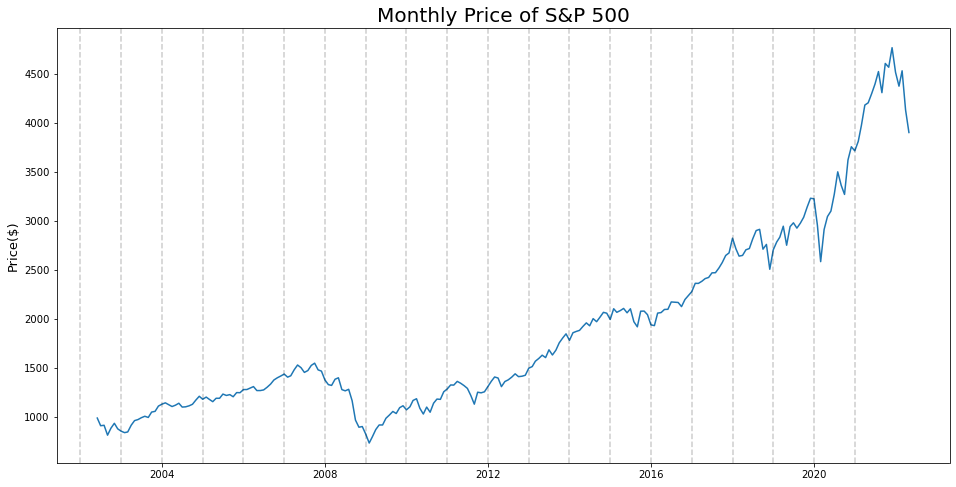

In [1109]:
plt.figure(figsize=(16,8))
plt.plot(lim_spx)
plt.title('Monthly Price of S&P 500', fontsize=20)
plt.ylabel('Price($)', fontsize=13)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1110]:
first_diff = lim_spx.diff()[1:]

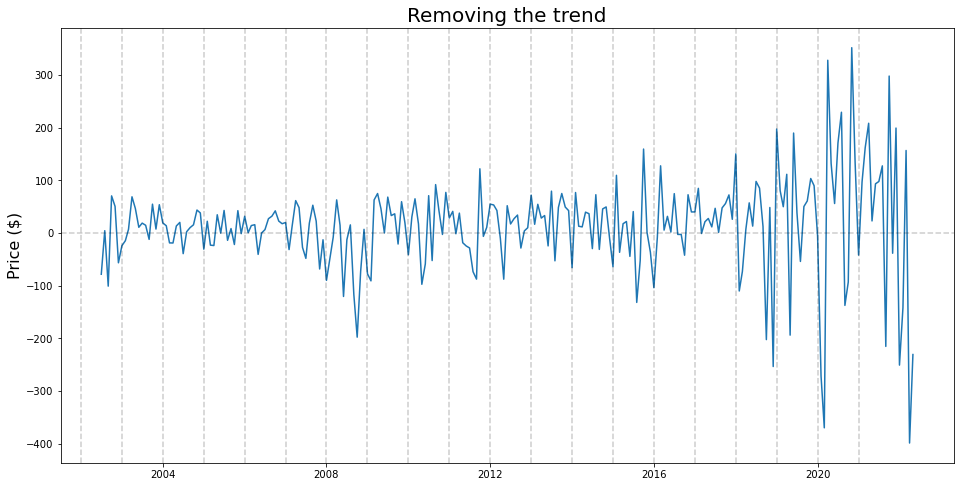

In [1111]:
plt.figure(figsize=(16,8))
plt.plot(first_diff)
plt.title('Removing the trend', fontsize=20)
plt.ylabel('Price ($)', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

<BarContainer object of 20 artists>

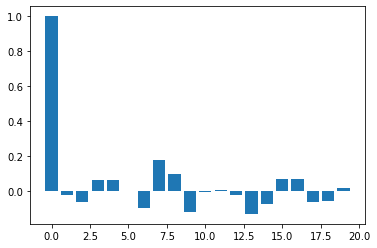

In [1113]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

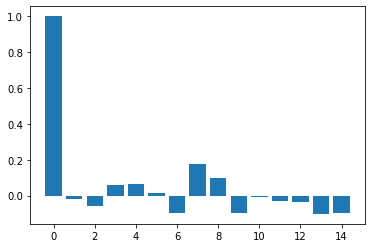

In [1115]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [1116]:
train_end = datetime(2021,5,1)
test_end = datetime(2022,5,1)

train_data = lim_spx[:train_end]
test_data = lim_spx[train_end + timedelta(days=1):test_end]

In [1117]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 7)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [1118]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.2825455665588379


In [1119]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Price   No. Observations:                  228
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1313.649
Date:                             Sun, 22 May 2022   AIC                           2633.297
Time:                                     13:07:15   BIC                           2643.572
Sample:                                 06-01-2002   HQIC                          2637.444
                                      - 05-01-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.0218      0.174      0.125      0.900      -0.319       0.363
ma.S.L7        0.2417      

In [1120]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

Text(0, 0.5, 'Error')

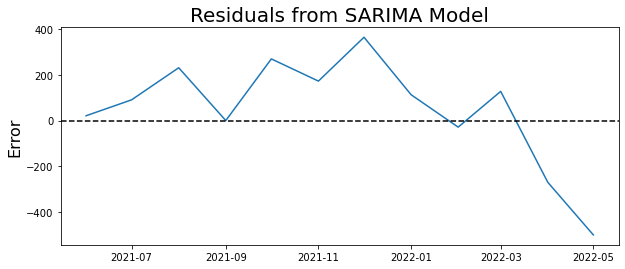

In [1121]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

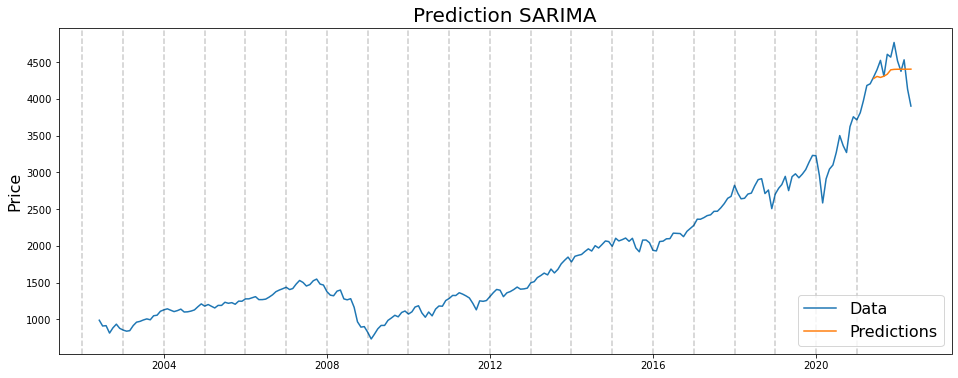

In [1122]:
plt.figure(figsize=(16,6))

plt.plot(lim_spx)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Prediction SARIMA', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1123]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.042


In [1124]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 233.59843464181276


In [1125]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_spx[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [1126]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

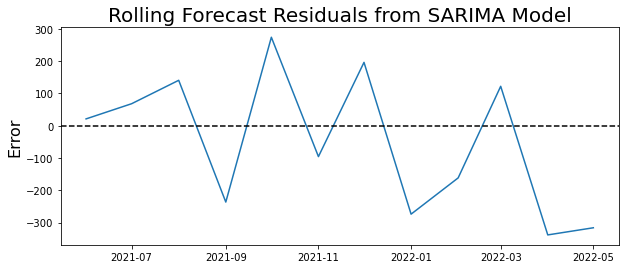

In [1127]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

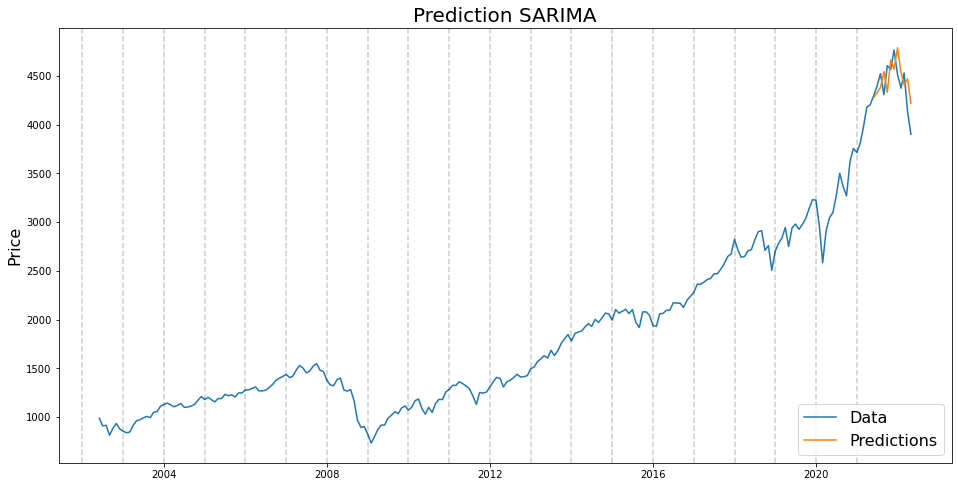

In [1128]:
plt.figure(figsize=(16,8))

plt.plot(lim_spx)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Prediction SARIMA', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1129]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0429


In [1130]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 210.83111667909475


In [ ]:
#attempt one for checking Anomoly (Deviation Differences)

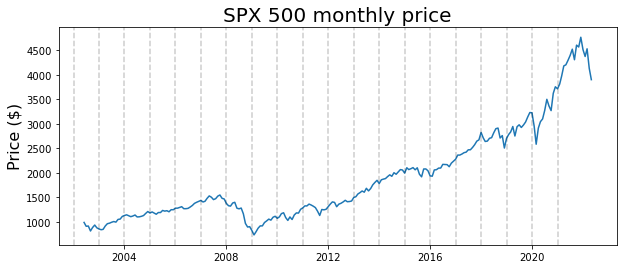

In [1138]:
plt.figure(figsize=(10,4))
plt.plot(lim_spx)
plt.title('SPX 500 monthly price', fontsize=20)
plt.ylabel('Price ($)', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1133]:
rolling_deviations = pd.Series(dtype=float, index = lim_catfish_sales.index)

In [1134]:
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = lim_spx.loc[:date]
    
    #get the deviation within this window
    rolling_deviations.loc[date] = window.std()

In [1135]:
#get the difference in deviation between one time point and the next
diff_rolling_deviations = rolling_deviations.diff()
diff_rolling_deviations = diff_rolling_deviations.dropna()

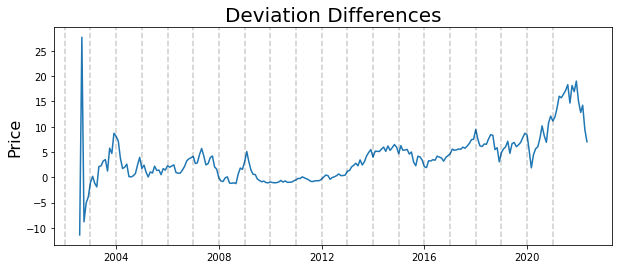

In [1139]:
plt.figure(figsize=(10,4))
plt.plot(diff_rolling_deviations)
plt.title('Deviation Differences', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1012]:
#attempt 2 for checking Anomaly (Deviation by Month)

In [1140]:
month_deviations = lim_spx.groupby(lambda d: d.month).std()

Text(0, 0.5, 'Sales')

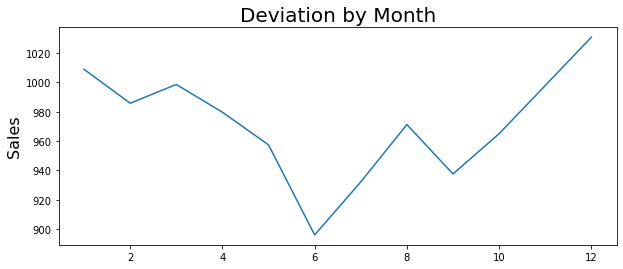

In [1141]:
plt.figure(figsize=(10,4))
plt.plot(month_deviations)
plt.title('Deviation by Month', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [1142]:
june_data = lim_spx[lim_spx.index.month == 6]

In [1143]:
june_data

Date
2002-06-01     989.82
2003-06-01     974.50
2004-06-01    1140.84
2005-06-01    1191.33
2006-06-01    1270.20
2007-06-01    1503.35
2008-06-01    1280.00
2009-06-01     919.32
2010-06-01    1030.71
2011-06-01    1320.64
2012-06-01    1362.16
2013-06-01    1606.28
2014-06-01    1960.23
2015-06-01    2063.11
2016-06-01    2098.86
2017-06-01    2423.41
2018-06-01    2718.37
2019-06-01    2941.76
2020-06-01    3100.29
2021-06-01    4297.50
Name: Price, dtype: float64

In [1144]:
min_dev = 9999999
curr_anomaly = None
for date in june_data.index:
    other_data = june_data[june_data.index != date]
    curr_dev = other_data.std()
    if curr_dev < min_dev:
        min_dev = curr_dev
        curr_anomaly = date

In [1028]:
curr_anomaly

Timestamp('2021-06-01 00:00:00')

In [ ]:
#ADDING ANOMALY INTO THE SARIMA PREDICTION

In [1145]:
adjusted_data = lim_spx.copy()
adjusted_data.loc[curr_anomaly] = june_data[(june_data.index != curr_anomaly) & (june_data.index < test_data.index[0])].mean()

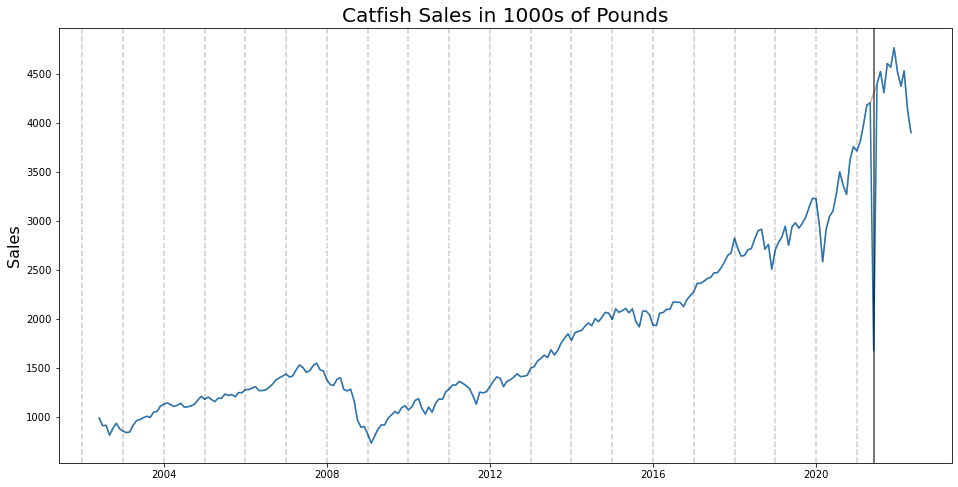

In [1146]:
plt.figure(figsize=(16,8))
plt.plot(lim_spx, color='firebrick', alpha=0.4)
plt.plot(adjusted_data)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axvline(curr_anomaly, color='k', alpha=0.7)

In [1147]:
train_end = datetime(2020,4,1)
test_end = datetime(2022,5,1)

test_data = adjusted_data[train_end + timedelta(days=1):test_end]

In [1148]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = adjusted_data[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

In [1149]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

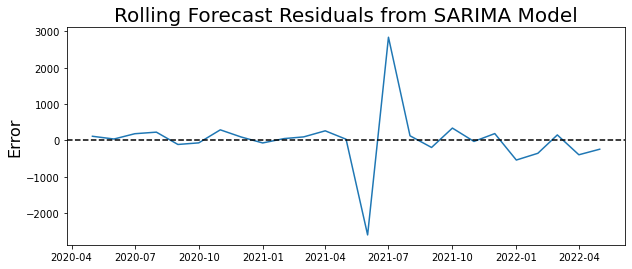

In [1150]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

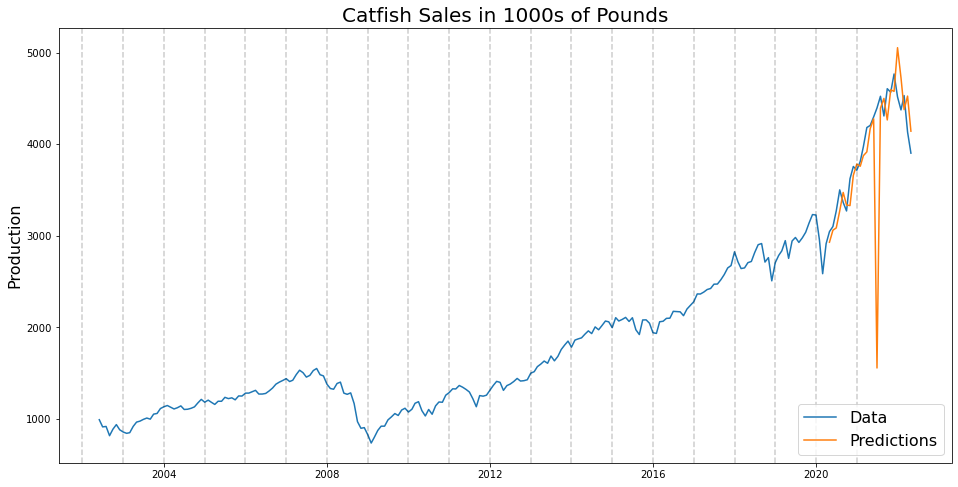

In [1151]:
plt.figure(figsize=(16,8))

plt.plot(lim_catfish_sales)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [1152]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.1295


In [1153]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 799.3647051043102


In [ ]:
#ATTEMPT THREE FOR ANOMALY DETECTION - SLT METHOD

Text(0, 0.5, 'Price')

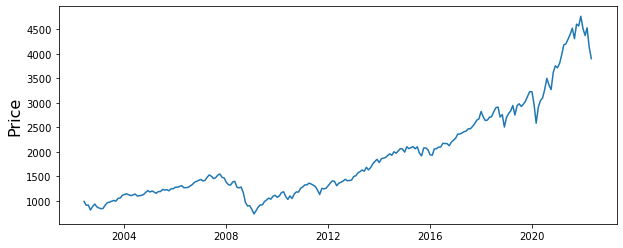

In [1155]:
interest = lim_spx
plt.figure(figsize=(10,4))
plt.plot(interest)
plt.ylabel('Price', fontsize=16)

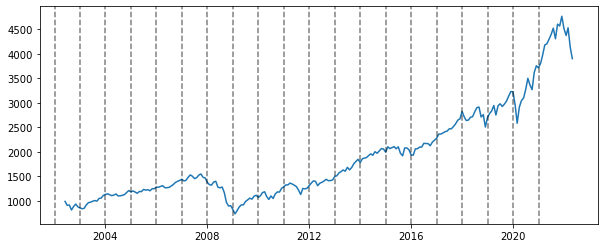

In [1156]:
plt.figure(figsize=(10,4))
plt.plot(interest)
for year in range(2002,2022):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

In [1157]:
stl = STL(interest)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

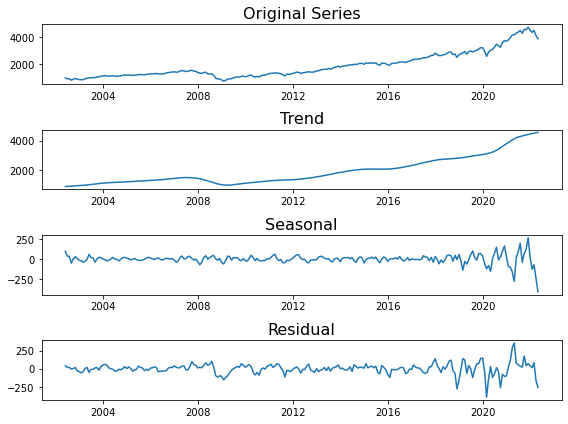

In [1158]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(interest)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

Text(0, 0.5, 'Price ($)')

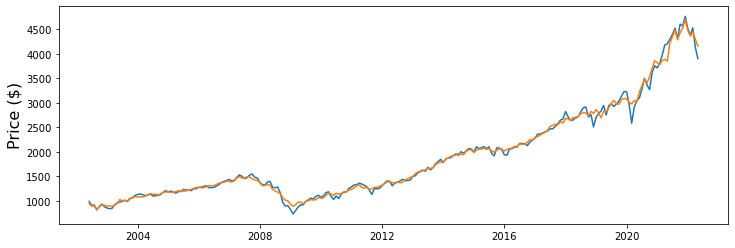

In [1159]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(interest)
plt.plot(estimated)
plt.ylabel('Price ($)', fontsize=16)

In [1160]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(11961.0, 19113.0)

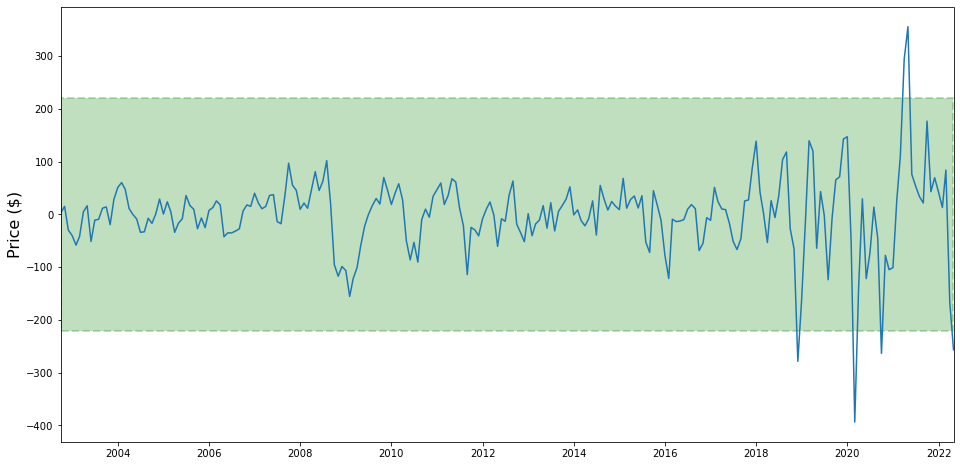

In [1161]:
plt.figure(figsize=(16,8))
plt.plot(resid)
plt.ylabel('Price ($)', fontsize=16)

plt.fill_between([datetime(2002,10,1), datetime(2022,5,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2002,10,1), datetime(2022,5,1))

In [1162]:
anomalies = interest[(resid < lower) | (resid > upper)]

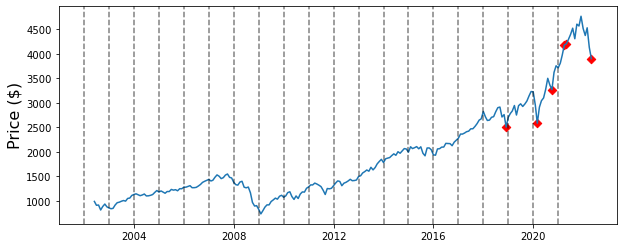

In [1163]:
plt.figure(figsize=(10,4))
plt.plot(interest)
plt.ylabel('Price ($)', fontsize=16)
for year in range(2002,2022):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies, color='r', marker='D')

In [1164]:
anomalies

Date
2018-12-01    2506.85
2020-03-01    2584.59
2020-10-01    3269.96
2021-04-01    4181.17
2021-05-01    4204.11
2022-05-01    3901.36
Name: Price, dtype: float64